## Import Statements

In [21]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem.snowball import GermanStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.tag.sequential import ClassifierBasedTagger
from nltk.corpus import ConllCorpusReader
from sklearn.utils import shuffle
from collections import OrderedDict
from sklearn.manifold import TSNE
%matplotlib inline

## Stopwords

In [2]:
sw = '''
aber           |  but

alle           |  all
allem
allen
aller
alles

als            |  than, as
also           |  so
am             |  an + dem
an             |  at

ander          |  other
andere
anderem
anderen
anderer
anderes
anderm
andern
anderr
anders

auch           |  also
auf            |  on
aus            |  out of
bei            |  by
bin            |  am
bis            |  until
bist           |  art
da             |  there
damit          |  with it
dann           |  then

der            |  the
den
des
dem
die
das

daß            |  that

derselbe       |  the same
derselben
denselben
desselben
demselben
dieselbe
dieselben
dasselbe

dazu           |  to that

dein           |  thy
deine
deinem
deinen
deiner
deines

denn           |  because

derer          |  of those
dessen         |  of him

dich           |  thee
dir            |  to thee
du             |  thou

dies           |  this
diese
diesem
diesen
dieser
dieses


doch           |  (several meanings)
dort           |  (over) there


durch          |  through

ein            |  a
eine
einem
einen
einer
eines

einig          |  some
einige
einigem
einigen
einiger
einiges

einmal         |  once

er             |  he
ihn            |  him
ihm            |  to him

es             |  it
etwas          |  something

euer           |  your
eure
eurem
euren
eurer
eures

für            |  for
gegen          |  towards
gewesen        |  p.p. of sein
hab            |  have
habe           |  have
haben          |  have
hat            |  has
hatte          |  had
hatten         |  had
hier           |  here
hin            |  there
hinter         |  behind

ich            |  I
mich           |  me
mir            |  to me


ihr            |  you, to her
ihre
ihrem
ihren
ihrer
ihres
euch           |  to you

im             |  in + dem
in             |  in
indem          |  while
ins            |  in + das
ist            |  is

jede           |  each, every
jedem
jeden
jeder
jedes

jene           |  that
jenem
jenen
jener
jenes

jetzt          |  now
kann           |  can

kein           |  no
keine
keinem
keinen
keiner
keines

können         |  can
könnte         |  could
machen         |  do
man            |  one

manche         |  some, many a
manchem
manchen
mancher
manches

mein           |  my
meine
meinem
meinen
meiner
meines

mit            |  with
muss           |  must
musste         |  had to
nach           |  to(wards)
nicht          |  not
nichts         |  nothing
noch           |  still, yet
nun            |  now
nur            |  only
ob             |  whether
oder           |  or
ohne           |  without
sehr           |  very

sein           |  his
seine
seinem
seinen
seiner
seines

selbst         |  self
sich           |  herself

sie            |  they, she
ihnen          |  to them

sind           |  are
so             |  so

solche         |  such
solchem
solchen
solcher
solches

soll           |  shall
sollte         |  should
sondern        |  but
sonst          |  else
über           |  over
um             |  about, around
und            |  and

uns            |  us
unse
unsem
unsen
unser
unses

unter          |  under
viel           |  much
vom            |  von + dem
von            |  from
vor            |  before
während        |  while
war            |  was
waren          |  were
warst          |  wast
was            |  what
weg            |  away, off
weil           |  because
weiter         |  further

welche         |  which
welchem
welchen
welcher
welches

wenn           |  when
werde          |  will
werden         |  will
wie            |  how
wieder         |  again
will           |  want
wir            |  we
wird           |  will
wirst          |  willst
wo             |  where
wollen         |  want
wollte         |  wanted
würde          |  would
würden         |  would
zu             |  to
zum            |  zu + dem
zur            |  zu + der
zwar           |  indeed
zwischen       |  between
'''

In [3]:
sw = sw.split('\n')
stopwords = []
for i in sw:
    if len(i) > 0:
        stopwords.append(i.split('|')[0].strip())
stopwords[:5]

['aber', 'alle', 'allem', 'allen', 'aller']

## Helper POS tagger and Lemmatizer, thanks internet

In [4]:
class ClassifierBasedGermanTagger(ClassifierBasedTagger):
    """A classifier based German part-of-speech tagger. It has an accuracy of
    96.09% after being trained on 90% of the German TIGER corpus. The tagger
    extends the NLTK ClassifierBasedTagger and implements a slightly modified
    feature detector.
    """

    def feature_detector(self, tokens, index, history):
        """Implementing a slightly modified feature detector.
        @param tokens: The tokens from the sentence to tag.
        @param index: The current token index to tag.
        @param history: The previous tagged tokens.
        """

        word = tokens[index]
        if index == 0: # At the beginning of the sentence
            prevword = prevprevword = None
            prevtag = prevprevtag = None
            #word = word.lower() # Lowercase at the beginning of sentence
        elif index == 1:
            prevword = tokens[index-1] # Note: no lowercase
            prevprevword = None
            prevtag = history[index-1]
            prevprevtag = None
        else:
            prevword = tokens[index-1]
            prevprevword = tokens[index-2]
            prevtag = history[index-1]
            prevprevtag = history[index-2]

        if re.match('[0-9]+([\.,][0-9]*)?|[0-9]*[\.,][0-9]+$', word):
            # Included "," as decimal point
            shape = 'number'
        elif re.compile('\W+$', re.UNICODE).match(word):
            # Included unicode flag
            shape = 'punct'
        elif re.match('([A-ZÄÖÜ]+[a-zäöüß]*-?)+$', word):
            # Included dash for dashed words and umlauts
            shape = 'upcase'
        elif re.match('[a-zäöüß]+', word):
            # Included umlauts
            shape = 'downcase'
        elif re.compile("\w+", re.UNICODE).match(word):
            # Included unicode flag
            shape = 'mixedcase'
        else:
            shape = 'other'

        features = {
            'prevtag': prevtag,
            'prevprevtag': prevprevtag,
            'word': word,
            'word.lower': word.lower(),
            'suffix3': word.lower()[-3:],
            #'suffix2': word.lower()[-2:],
            #'suffix1': word.lower()[-1:],
            'preffix1': word[:1], # included
            'prevprevword': prevprevword,
            'prevword': prevword,
            'prevtag+word': '%s+%s' % (prevtag, word),
            'prevprevtag+word': '%s+%s' % (prevprevtag, word),
            'prevword+word': '%s+%s' % (prevword, word),
            'shape': shape
            }
        return features

In [5]:
corp = ConllCorpusReader('.', 'tiger_release_aug07.corrected.16012013.conll09',
                                     ['ignore', 'words', 'ignore', 'ignore', 'pos'],
                                     encoding='utf-8')

In [6]:
tagged_sents = corp.tagged_sents()
shuffle(tagged_sents)
split_perc = 0.1
split_size = int(len(tagged_sents) * split_perc)
train_sents, test_sents = tagged_sents[split_size:], tagged_sents[:split_size]

In [7]:
def read_lemmata_from_tiger_corpus(tiger_corpus_file, valid_cols_n=15, col_words=1, col_lemmata=2):
    lemmata_mapping = {}

    with open(tiger_corpus_file) as f:
        for line in f:
            parts = line.split()
            if len(parts) == valid_cols_n:
                w, lemma = parts[col_words], parts[col_lemmata]
                if w != lemma and w not in lemmata_mapping and not lemma.startswith('--'):
                    lemmata_mapping[w] = lemma

    return lemmata_mapping

In [8]:
lemmata_mapping = read_lemmata_from_tiger_corpus('tiger_release_aug07.corrected.16012013.conll09')

In [9]:
def lemmatize_german(corpus):
    lemmata = []
    for w in corpus:
        w_lemma = lemmata_mapping.get(w, None)
        if w_lemma:
            lemmata.append(w_lemma)
        else:
            lemmata.append(w)
    return lemmata

## Function that creates the Word2Vec models

In [10]:
names = [
    'augsburger_allgemeine',
    'badische_zeitung',
    'berliner_zeitung',
    'frankfurter_allgemeine_zeitung',
    'koelner_stadt_anzeiger',
    'leipziger_volkszeitung',
    'mitteldeutsche_zeitung',
    'rheinische_post',
    'saechsische_zeitung',
    'stuttgarter_zeitung',
    'sueddeutsche_zeitung',
    'weser_kurier',
]

In [11]:
# Helper fxn
def combine_headlines(df, filename):
    if 'article_headline_strong' in df.columns:
        df['article_headline'] = df['article_headline_strong'] + " " + df['article_headline_normal']
        df.drop(['article_headline_strong', 'article_headline_normal'], axis=1, inplace=True)
    return df

In [12]:
# Helper fxn
def prep_article(df):
    df.article_text = df.article_text.apply(lambda x: ' '.join(x))
    return df

In [69]:
def create_word_embeddings(setting):
    if setting == "east":
        names = [
            "leipziger_volkszeitung",
            "mitteldeutsche_zeitung",
            "saechsische_zeitung",
        ]
    elif setting == "west":
        names = [
            "augsburger_allgemeine",
            "badische_zeitung",
            "koelner_stadt_anzeiger",
            "rheinische_post",
            "stuttgarter_zeitung",
            "weser_kurier",
        ]
    elif setting == "intl":
        names = [
            "berliner_zeitung",
            "frankfurter_allgemeine_zeitung",
            "sueddeutsche_zeitung"
        ]
        
    filenames = []
    dates = ["oct31", 'nov1', 'nov2', 'nov3', 'nov4', 'nov5', 'nov6', 'nov7', 'nov8']
    for name in names:
        for date in dates:
            filename = "data/" + name + "/" + name + "_" + date + ".json"
            filenames.append(filename)

    dfs = []
    for filename in filenames:
        try:
            with open(filename, 'r') as f_obj:
                df = pd.read_json(f_obj)
        except FileNotFoundError:
            print("\nERROR :::: ", filename, "\n")
        else:
            df['source'] = filename.split('/')[1]
            combine_headlines(df, filename)
            prep_article(df)
            print("Success: ", filename)
            dfs.append(df)
    
    df = pd.concat(dfs)
    
    corpus = []
    gsm = GermanStemmer()
    for row in df.iterrows():
        article_text = row[1][2]
        article_text = re.sub(r'[^A-Za-zäüöß ]*', '', article_text)
        article_text = article_text.lower()
        stemmed = gsm.stem(article_text)
        tokenized = word_tokenize(stemmed)
        lemmatized = lemmatize_german(tokenized)
        corpus.append(lemmatized)
        # not removing sw's
    model = gensim.models.Word2Vec(corpus, size=300, window=10, min_count=3, workers=2,sg=1)
    return model

## Create the Word2Vecs

In [70]:
east = create_word_embeddings('east')
west = create_word_embeddings('west')
intl = create_word_embeddings('intl')

Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_oct31.json
Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_nov1.json
Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_nov2.json
Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_nov3.json
Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_nov4.json
Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_nov5.json
Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_nov6.json
Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_nov7.json
Success:  data/leipziger_volkszeitung/leipziger_volkszeitung_nov8.json
Success:  data/mitteldeutsche_zeitung/mitteldeutsche_zeitung_oct31.json
Success:  data/mitteldeutsche_zeitung/mitteldeutsche_zeitung_nov1.json
Success:  data/mitteldeutsche_zeitung/mitteldeutsche_zeitung_nov2.json
Success:  data/mitteldeutsche_zeitung/mitteldeutsche_zeitung_nov3.json
Success:  data/mitteldeutsche_zeitung/mitteldeutsche_zeitung_nov4.json
Succ

## Word2Vec Exploration

In [16]:
def examine_word(word):
    print("WEST:")
    for i in west.most_similar(word, topn=5):
        print(i)
    print("\nEAST:")
    for i in east.most_similar(word, topn=5):
        print(i)
    print("\nINTL:")
    for i in intl.most_similar(word, topn=5):
        print(i)

## Scale the `examine` function

In [147]:
def examine(word):
    print("WEST:")
    try:
        w = west.most_similar(word, topn=15)
    except KeyError:
        print("WARNING: " + word + " not in corpus")
    else:
        for i in w:
            print(i)
    print("\nEAST:")
    try:
        e = east.most_similar(word, topn=15)
    except KeyError:
        print("WARNING: " + word + " not in corpus")
    else:
        for i in e:
            print(i)
    print("\nINTL:")
    try:
        t = intl.most_similar(word, topn=15)
    except KeyError:
        print("WARNING: " + word + " not in corpus")
    else:
        for i in t:
            print(i)

In [148]:
def examine_terms(term_list):
    for term in term_list:
        print("\n\n*** " + term.upper() + " ***\n")
        examine(term)

## Term List

In [206]:
terms = ['jamaika', 'osten', 'westen', 'deutschland', 'sozial',
'national', 'polnisch', 'russland', 'infrastruktur',
'frank', 'trump', 'einwohner', 'global', 'puigdemont',
'bayern', 'gesellschaft', 'europa', 'york', 'anklage',
'spacey', 'zahlung', 'krise', 'heimat', 'halloween',
'zombies', 'prasident', 'arabisch', 'ddr', 'bundesrepublik',
'russisch', 'afd', 'cdu', 'csu', 'fdp', 'grunen', 'spd',
'alternativ', 'union', 'sondierung', 'arbeitslosigkeit',
'haftbefehl', 'fluchtling', 'frauen', 'jobs', 'wirtschaft',
'haushalte', 'hierzulande', 'land', 'tradition', 'eu',
'arbeitnehmer', 'erhohung', 'verlust', 'paradise', 'appleby',
'mann', 'kind', 'panama', 'steuer', 'kevin', 'sohn', 'tochter',
'vater', 'mutter', 'freund', 'freundin']

In [207]:
countries = [
    'deutschland', 'deutsch', 'usa', 'amerikanisch', 'eu', 'europa',
    'frankreich', 'polnisch', 'russland', 'russisch', 'china', 'chinesisch',
    'turkei', 'schweiz', 'schweizer', 'japan', 'japanisch', #'korea',
    'kanada', 'mexiko', 'brasilien', 'iran',
    'italien', 'italienisch', 'britisch', 'vergangenheit'
]

In [213]:
terms2 = ['jamaika', 'osten', 'westen', 'deutschland', 'sozial',
'national', 'polnisch', 'russland', 'infrastruktur',
'frank', 'trump', 'einwohner', 'global', 'puigdemont',
'bayern', 'gesellschaft', 'europa', 'york', 'anklage',
'spacey', 'zahlung', 'krise', 'heimat', 'halloween',
'zombies', 'prasident', 'arabisch', 'ddr', 'bundesrepublik',
'russisch', 'afd', 'cdu', 'csu', 'fdp', 'grunen', 'spd',
'alternativ', 'union', 'arbeitslosigkeit',
'haftbefehl', 'fluchtling', 'frauen', 'jobs', 'wirtschaft',
'haushalte', 'hierzulande', 'land', 'tradition', 'eu',
'arbeitnehmer', 'erhohung', 'verlust', 'paradise', 'appleby',
'mann', 'kind', 'panama', 'steuer', 'kevin', 'sohn', 'tochter',
'vater', 'mutter', 'freund', 'freundin']

## Examine Term List

In [208]:
examine_terms(terms)



*** JAMAIKA ***

WEST:
('goringeckardt', 0.9567314982414246)
('einerseits', 0.9449784755706787)
('parteichef', 0.9436694979667664)
('chefsache', 0.9433469176292419)
('dialog', 0.9410197734832764)
('jamaikasondierungen', 0.940637469291687)
('vielmehr', 0.9373767375946045)
('strikt', 0.9358271360397339)
('digitalisierung', 0.9341267943382263)
('cducsu', 0.9337408542633057)
('tagesordnung', 0.9313472509384155)
('instrument', 0.930921196937561)
('kohleausstieg', 0.9304817914962769)
('paket', 0.9304091930389404)
('anstrengen', 0.9300211071968079)

EAST:
('inwiefern', 0.9903132915496826)
('provisorium', 0.9902699589729309)
('nancy', 0.989784836769104)
('originalschraube', 0.9894886612892151)
('beidem', 0.9894673228263855)
('verstandigen', 0.9891577363014221)
('hoffentlich', 0.9885408878326416)
('moller', 0.9879125356674194)
('gastronomie', 0.9879000186920166)
('neuigkeiten', 0.9878957271575928)
('tagebuch', 0.9878666400909424)
('erkenntnis', 0.9878333806991577)
('auszubildende', 0.98777735

('jahrzehnten', 0.8197445273399353)
('rivale', 0.818352222442627)
('stabil', 0.8178525567054749)
('einstieg', 0.8135537505149841)
('erzeugen', 0.8131614327430725)
('eu', 0.8129504919052124)
('einerseits', 0.8129309415817261)


*** YORK ***

WEST:
('new', 0.963126003742218)
('jersey', 0.8932501673698425)
('yorker', 0.8912848234176636)
('times', 0.8679087162017822)
('yorks', 0.862536609172821)
('cuomo', 0.8585624694824219)
('bill', 0.8523738980293274)
('zutiefst', 0.8518280982971191)
('terrorattacke', 0.8480079770088196)
('obama', 0.8414360284805298)
('bush', 0.8352853059768677)
('bundesstaat', 0.8325629234313965)
('festanstellung', 0.8204268217086792)
('blasio', 0.8191937208175659)
('barack', 0.8185003995895386)

EAST:
('new', 0.96009761095047)
('times', 0.9285722970962524)
('fruhere', 0.9027780890464783)
('donald', 0.895267903804779)
('bekaert', 0.892015814781189)
('usprasident', 0.8883036375045776)
('yorker', 0.8811492919921875)
('trumps', 0.8803455829620361)
('spanisch', 0.8780640959

('angela', 0.9251507520675659)
('union', 0.9211766719818115)
('kanzlerin', 0.8942097425460815)
('cdu', 0.8899435997009277)
('seehofer', 0.8885343670845032)
('feiks', 0.886472761631012)
('linker', 0.8837441205978394)
('trauern', 0.8790769577026367)
('bestatigt', 0.8735001087188721)
('beteiligen', 0.869488537311554)
('schollbach', 0.8648728132247925)

INTL:
('union', 0.9468095302581787)
('grunen', 0.9431692957878113)
('grune', 0.9392205476760864)
('csu', 0.9059613347053528)
('cdu', 0.8995718955993652)
('koalition', 0.8685286045074463)
('zustimmung', 0.834266185760498)
('sondierungen', 0.8279411196708679)
('lindner', 0.8113782405853271)
('merkel', 0.7988821268081665)
('scheitern', 0.7983437776565552)
('bildung', 0.7967674136161804)
('beteiligen', 0.7932433485984802)
('afd', 0.787785530090332)
('liberal', 0.7809427976608276)


*** GRUNEN ***

WEST:
('fdp', 0.9043726921081543)
('csu', 0.8646700382232666)
('jamaikakoalition', 0.8421762585639954)
('union', 0.8393816947937012)
('grune', 0.8341

('vereinbaren', 0.911482572555542)
('markten', 0.9109580516815186)


*** ARBEITNEHMER ***

WEST:
('pauschal', 0.9300801753997803)
('sprit', 0.9250062108039856)
('mittel', 0.9116410613059998)
('arbeitgeber', 0.9079549908638)
('eingeschrankt', 0.9040980935096741)
('Versicherung', 0.8995615243911743)
('verbrauch', 0.8962020874023438)
('belastung', 0.8952636122703552)
('diesel', 0.8947117328643799)
('hohere', 0.8924630284309387)
('cannabis', 0.8896768689155579)
('hnliches', 0.8886048793792725)
('autobauer', 0.8885625600814819)
('dienstwagen', 0.8872005343437195)
('modelle', 0.8869093656539917)

EAST:
('weihnachtsgeld', 0.9428380131721497)
('tarifvertrag', 0.9250236749649048)
('preise', 0.9201065897941589)
('eu', 0.9083877801895142)
('virusstamme', 0.8970696926116943)
('drittel', 0.8955810070037842)
('abweichungen', 0.8944919109344482)
('landwirtschaft', 0.8942834734916687)
('einzelhandel', 0.8930212259292603)
('angebot', 0.8925751447677612)
('branchen', 0.891709566116333)
('dak', 0.8901226

('schrecklich', 0.8909671306610107)

EAST:
('genießen', 0.9670142531394958)
('zweifeln', 0.9666088819503784)
('dame', 0.9665912985801697)
('verungluckten', 0.9607679843902588)
('karla', 0.9581223726272583)
('dohler', 0.9554870128631592)
('oma', 0.9549176692962646)
('nachbar', 0.95366370677948)
('wach', 0.9532996416091919)
('satz', 0.9525051116943359)
('bruder', 0.9520151615142822)
('glucklichste', 0.9511737823486328)
('kindheit', 0.9499078989028931)
('gedanke', 0.948706865310669)
('hande', 0.9469741582870483)

INTL:
('ricardo', 0.981969952583313)
('ulrike', 0.9819109439849854)
('geburtstag', 0.9763066172599792)
('verteidiger', 0.9722414016723633)
('genießen', 0.9710603952407837)
('graffiti', 0.9698194861412048)
('horte', 0.9690728187561035)
('schreien', 0.9680720567703247)
('benennen', 0.9678682088851929)
('telefonierte', 0.9675579071044922)
('vlada', 0.9675239324569702)
('jeglicher', 0.9669128656387329)
('anrufen', 0.9650569558143616)
('conny', 0.9639190435409546)
('omar', 0.963390111

## TSNE 

In [209]:
def tsne_plot(model, terms):
    tsne_model = TSNE(n_components=2)
    down_projection = tsne_model.fit_transform(model[terms])
    x = down_projection[: , 0]
    y = down_projection[: , 1]
    

    plt.figure(figsize=(20,10))
    plt.title("TSNE Plot of Word Embeddings", fontsize=20)
    plt.scatter(x, y)
    for i in range(len(terms)):
        plt.annotate(terms[i].title(), xy=(x[i], y[i]))

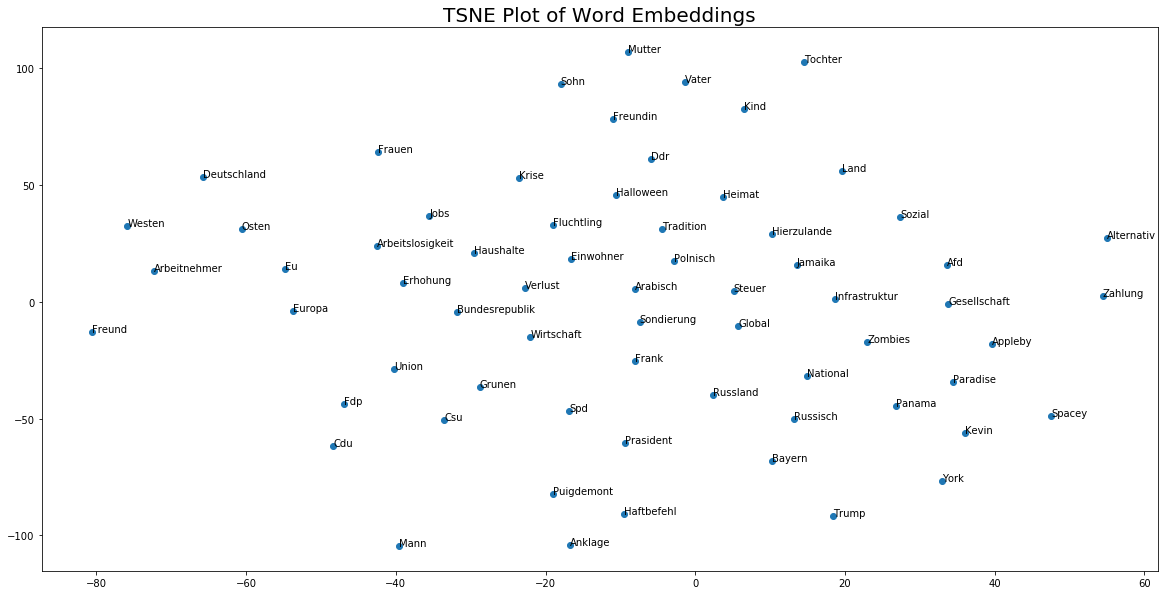

In [217]:
tsne_plot(east, terms)
#plt.savefig('east.svg', bbox_inches='tight')

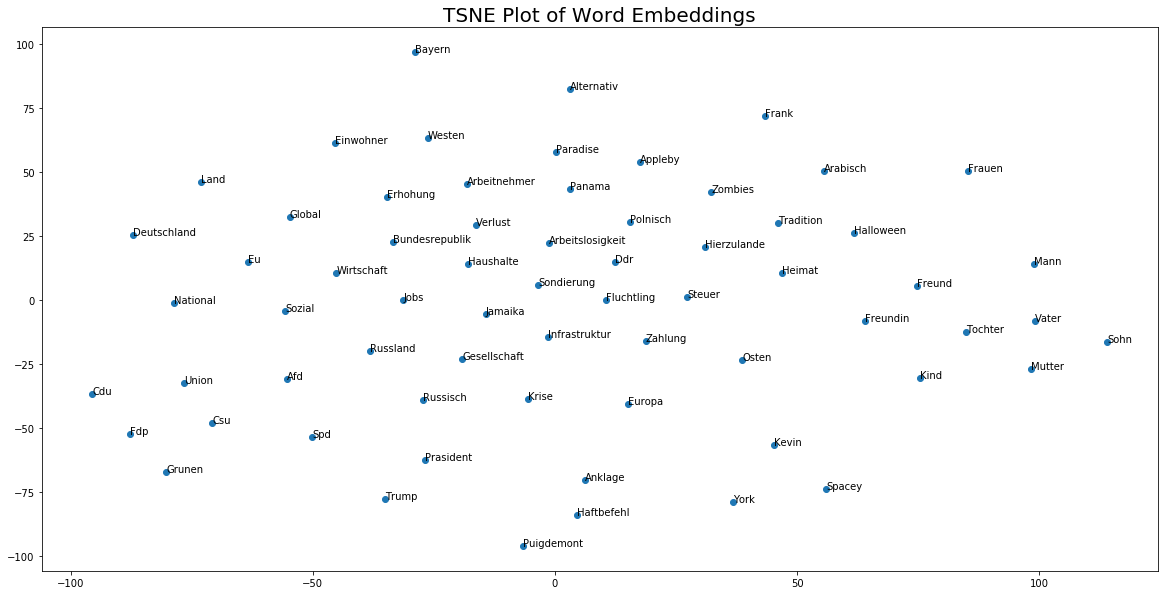

In [218]:
tsne_plot(west, terms)
plt.savefig('west.svg', bbox_inches='tight')

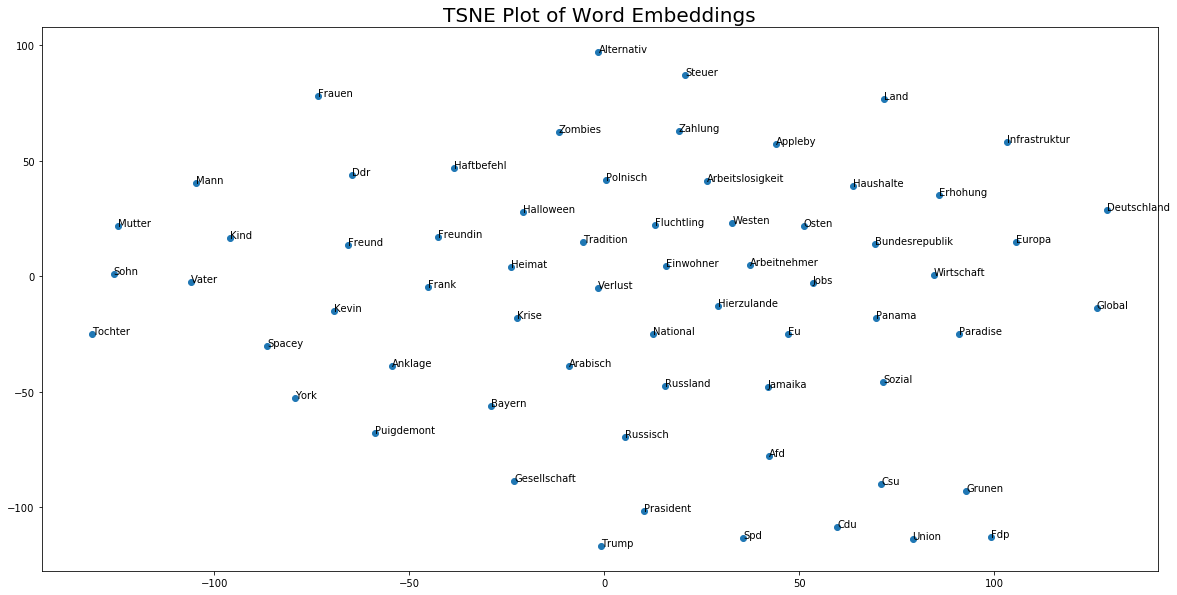

In [219]:
tsne_plot(intl, terms2)
plt.savefig('intl.svg', bbox_inches='tight')